In [1]:
# model_name = "Original_Pretrained_R2plus1D_18_MotionNet.pth"

model_name = "dropout_v3_0_10_R2plus1D_18_MotionNet.pth"

In [2]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.misc import load_model_by_name

# for finding lv seg borders
import cv2 as cv


# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.02it/s]


In [3]:
model_save_path = f"save_models/{model_name}"
    
model = load_model_by_name(model_name, model_save_path)

/home/wmw015/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/wmw015/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


gpus detected: 4
using cuda
dropout_v3_0_10_R2plus1D_18_MotionNet.pth has 31575731 parameters.


In [4]:
from src.strain import *
%matplotlib widget

In [5]:
curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(test_pat_index = 0, 
                                                                                                                test_dataset = test_dataset, 
                                                                                                                model = model)

In [6]:
curr_clip_segmentations.shape

(2, 32, 112, 112)

In [7]:
ed_label_boundary = cut_basal_plane_out(give_boundary(ed_label))
es_label_boundary = cut_basal_plane_out(give_boundary(es_label))

In [8]:
ed_seg_out = np.argmax(curr_clip_segmentations,0)[0]
es_seg_out = np.argmax(curr_clip_segmentations,0)[delta_ed_es]

ed_seg_out_boundary = cut_basal_plane_out(give_boundary(ed_seg_out))
es_seg_out_boundary = cut_basal_plane_out(give_boundary(es_seg_out))

In [9]:
ed_logits = np.array([curr_clip_segmentations[:,0,...]])
es_logits = np.array([curr_clip_segmentations[:,delta_ed_es,...]])

ed_warp = warp_backward(es_logits, curr_clip_motions, delta_ed_es, clip_index, debug = False)
es_warp = warp_forward(ed_logits, curr_clip_motions, delta_ed_es, clip_index, debug = False)

ed_warp = np.argmax(ed_warp[0], 0)
es_warp = np.argmax(es_warp[0], 0)

ed_warp_boundary = cut_basal_plane_out(give_boundary(ed_warp))
es_warp_boundary = cut_basal_plane_out(give_boundary(es_warp))

ed_warp.shape, es_warp.shape

/home/wmw015/.local/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


((112, 112), (112, 112))

Boundary Comparisons:
Dice (GT, Seg): 0.40186911821365356
Dice (GT, Warp): 0.3888888657093048
Dice (Seg, Warp): 0.8761904239654541


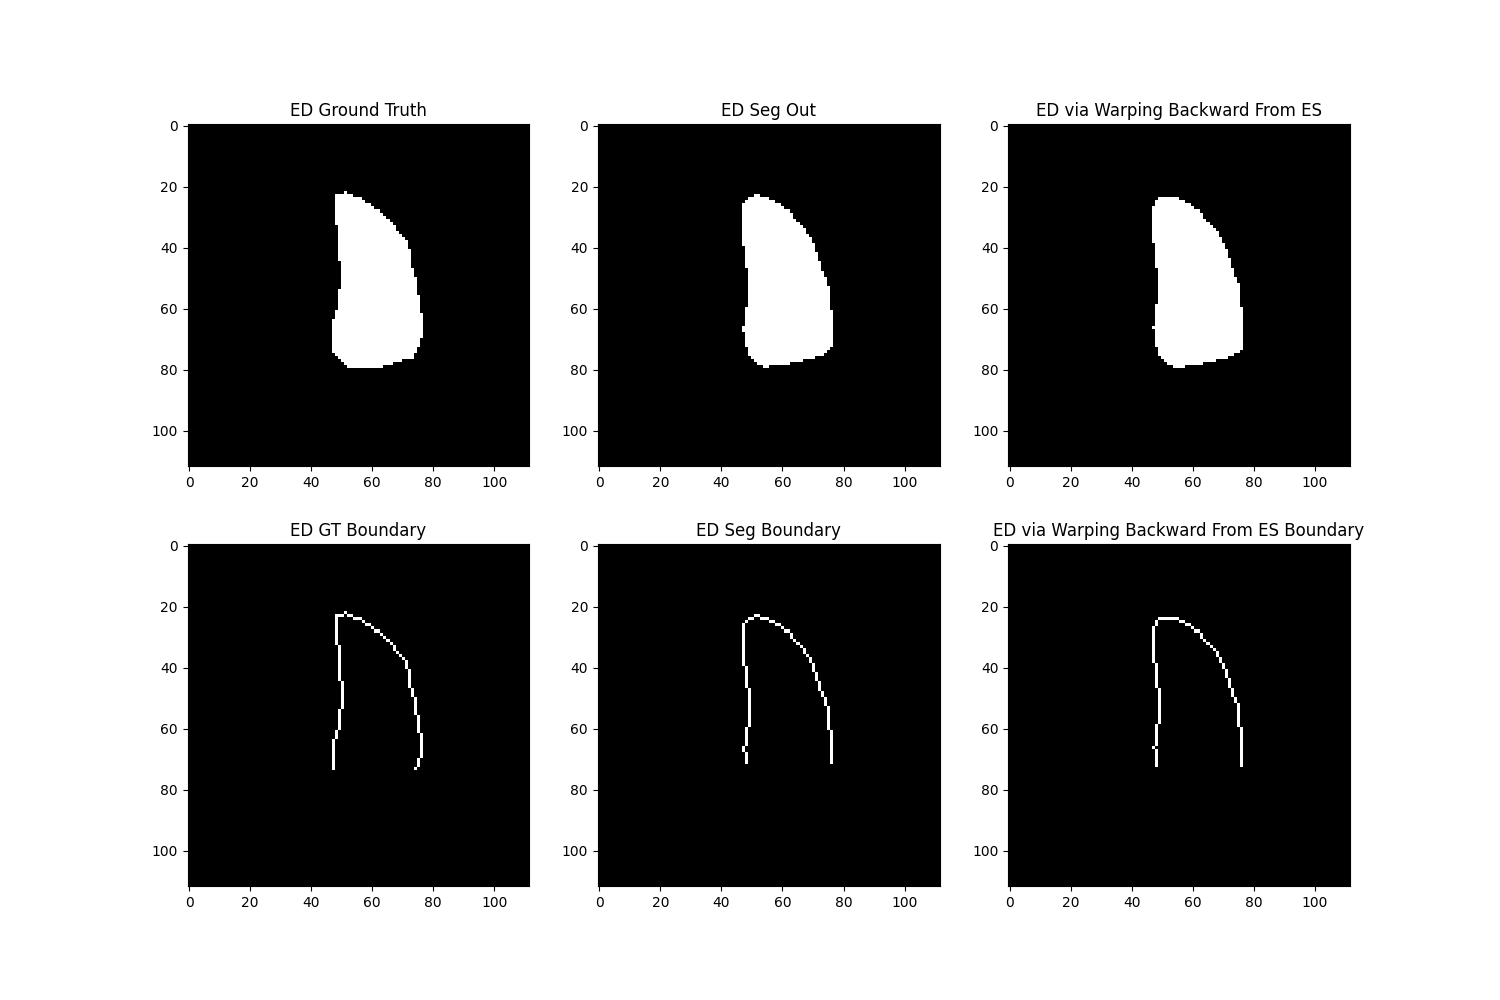

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0][0].set_title('ED Ground Truth')
ax[0][0].imshow(ed_label, cmap='gray')

ax[0][1].set_title('ED Seg Out')
ax[0][1].imshow(ed_seg_out, cmap='gray')

ax[0][2].set_title('ED via Warping Backward From ES')
ax[0][2].imshow(ed_warp, cmap='gray')

ax[1][0].set_title('ED GT Boundary')
ax[1][0].imshow(ed_label_boundary, cmap='gray')

ax[1][1].set_title('ED Seg Boundary')
ax[1][1].imshow(ed_seg_out_boundary, cmap='gray')

ax[1][2].set_title('ED via Warping Backward From ES Boundary')
ax[1][2].imshow(ed_warp_boundary, cmap='gray')

print('Boundary Comparisons:')
print(f'Dice (GT, Seg): {get_dice(ed_label_boundary, ed_seg_out_boundary)}')
print(f'Dice (GT, Warp): {get_dice(ed_label_boundary, ed_warp_boundary)}')
print(f'Dice (Seg, Warp): {get_dice(ed_seg_out_boundary, ed_warp_boundary)}')

Boundary Comparisons:
Dice (GT, Seg): 0.2666666507720947
Dice (GT, Warp): 0.18888887763023376
Dice (Seg, Warp): 0.8539324998855591


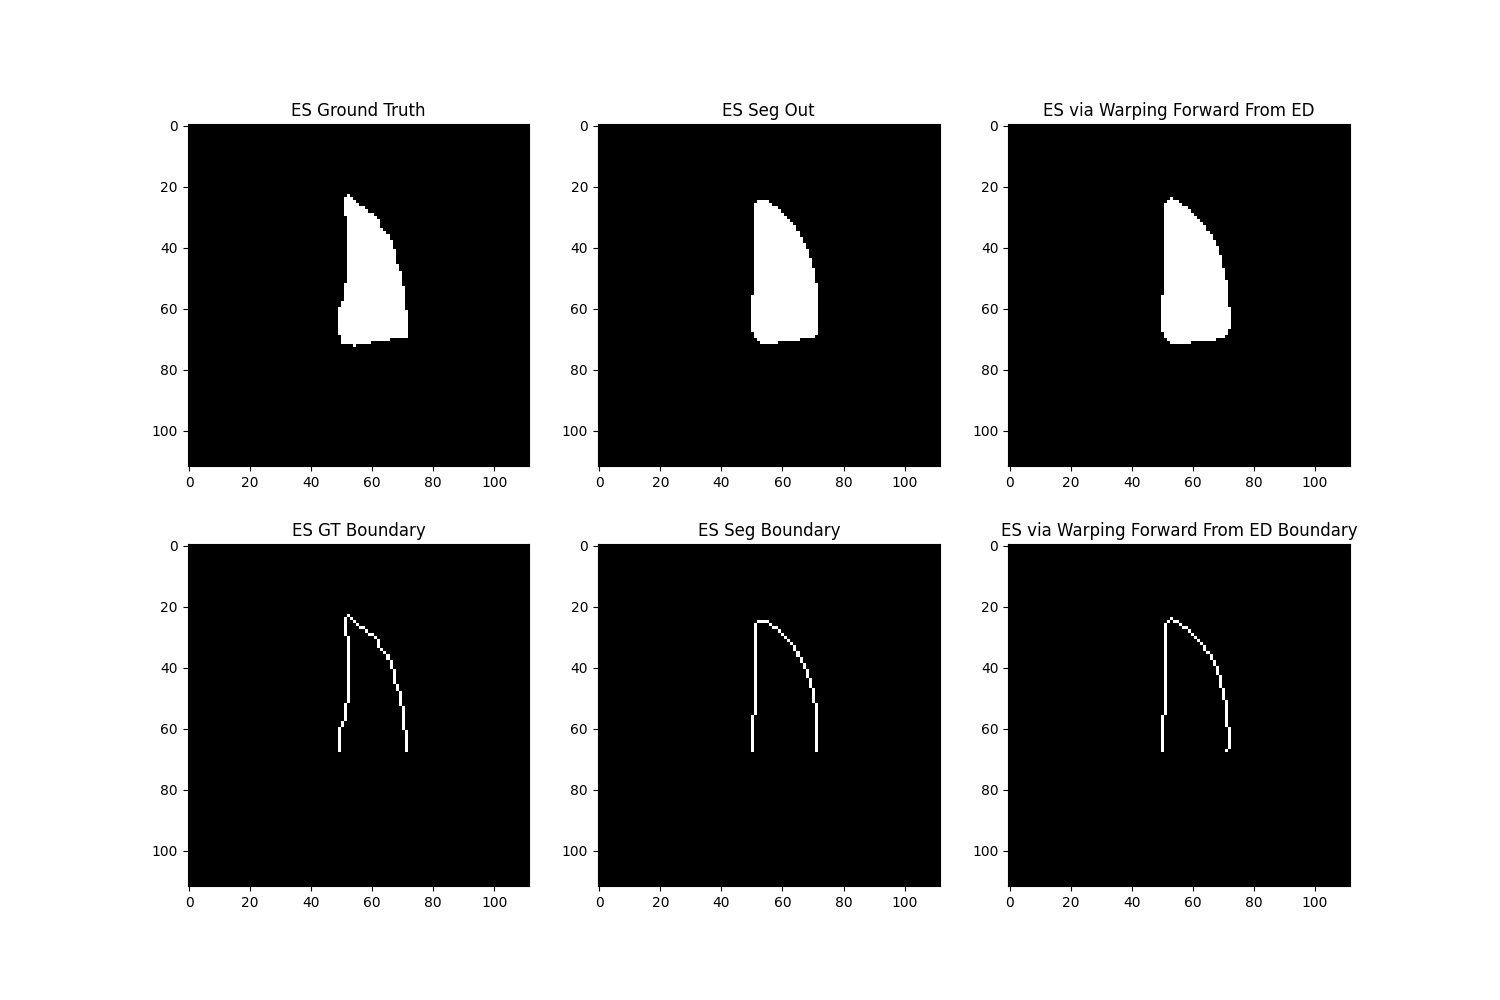

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0][0].set_title('ES Ground Truth')
ax[0][0].imshow(es_label, cmap='gray')

ax[0][1].set_title('ES Seg Out')
ax[0][1].imshow(es_seg_out, cmap='gray')

ax[0][2].set_title('ES via Warping Forward From ED')
ax[0][2].imshow(es_warp, cmap='gray')

ax[1][0].set_title('ES GT Boundary')
ax[1][0].imshow(es_label_boundary, cmap='gray')

ax[1][1].set_title('ES Seg Boundary')
ax[1][1].imshow(es_seg_out_boundary, cmap='gray')

ax[1][2].set_title('ES via Warping Forward From ED Boundary')
ax[1][2].imshow(es_warp_boundary, cmap='gray')

print('Boundary Comparisons:')
print(f'Dice (GT, Seg): {get_dice(es_label_boundary, es_seg_out_boundary)}')
print(f'Dice (GT, Warp): {get_dice(es_label_boundary, es_warp_boundary)}')
print(f'Dice (Seg, Warp): {get_dice(es_seg_out_boundary, es_warp_boundary)}')

In [12]:
gt_strain = images_to_strain(ed_label, es_label)
seg_strain = images_to_strain(ed_seg_out, es_seg_out)
warp_strain = images_to_strain(ed_warp, es_warp)

print(f'Ground Truth Strain: {gt_strain}')
print(f'Seg Out Strain: {seg_strain}')
print(f'Warp Strain: {warp_strain}')

print(f'\nRMSE(GT, Seg): {rmse(gt_strain, seg_strain)}')
print(f'RMSE(GT, Warp): {rmse(gt_strain, warp_strain)}')
print(f'RMSE(Seg, Warp): {rmse(seg_strain, warp_strain)}')

Ground Truth Strain: -0.17592592592592593
Seg Out Strain: -0.14705882352941177
Warp Strain: -0.16346153846153846

RMSE(GT, Seg): 0.02886710239651416
RMSE(GT, Warp): 0.012464387464387466
RMSE(Seg, Warp): 0.016402714932126694
